In [194]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [195]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import julian
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle
import datetime
from datetime import datetime
from tcrisk.vulnerability import vulnerability

# Python3 code to remove spaces from string
def remove(string):
    return string.replace(" ", "")


# Root directory: 
Replace with wherever data is downloaded to.

In [1]:
root_dir = '/data2/jbaldwin/WCAS2023'

# Set bounding box for Philippines

In [196]:
#Bounding Box for Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625

# Load swath data

In [197]:
ds_swaths = xr.open_dataset(root_dir+'/HAZARD/WIND_SWATHS/IBTrACS/wspd_phi_swaths_maxasymcorrec_ibtracsv04r00_3-8-21.nc')
swath = ds_swaths.swath

# Calculate understandable dates for each storm

In [198]:
# Convert modified Julian days to date-time objects
nmax = len(ds_swaths.nS)
imax = len(ds_swaths.iT)
dt = np.full([nmax, imax], np.nan, dtype='datetime64[s]')
month = np.full([nmax, imax], np.nan)
day = np.full([nmax, imax], np.nan)
for n in range(nmax):
    mjd = ds_swaths.days[n,:]
    for i in np.where(~np.isnan(mjd))[0]:
        x = julian.from_jd(mjd[i], fmt='mjd').date()
        dt[n][i] = x
        month[n,i] = int(x.month)
        day[n,i] = int(x.day)
year = ds_swaths.year.values
    

# Convert to datetime format
dt2 = []
for i in range(len(dt)):
    dt2.append(dt[i][0].astype(datetime))

# Calculate TC start and end dates
tc_start_date = np.min(dt,axis=1)
tc_end_date = np.max(dt,axis=1)

# Calculate duration of years
dyear = dt2[-1].year-dt2[0].year

# Load exposed value data

In [199]:
# Exposed Value Data, subset over Philippines
ds_exp = xr.open_dataset(root_dir+'/EXPOSED_VALUE/LITPOP/litpop_v1-2_phl.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
exposed_value = ds_exp.value

# Regrid swaths to exposed value data

In [200]:
# Determine Regridder for Hazard --> Exposed Value
regridder = xe.Regridder(swath, ds_exp, 'bilinear',reuse_weights=True)


# Regrid wind swath to exposed value grid
swath_out = regridder(swath)


Reuse existing file: bilinear_146x111_1551x1123.nc


# Load Philippines region masks

In [201]:
# rename lat and lon dimensions to be consistent with asset loss data
d_mask = xr.open_dataset(root_dir+'/REGION_MASKS/philippines_province_masks_newlitpopgrid.nc').rename({'longitude':'lon','latitude':'lat'})
pickle_in = open(root_dir+'/REGION_MASKS/state_ids.p',"rb")
state_ids = pickle.load(pickle_in)
regions = list(state_ids.keys())
mask = {}
for key in regions:
    mask0 = d_mask.states.where(d_mask.states==state_ids[key])
    mask[key] = mask0/mask0

# Calculate max wind in each region for each storm

In [204]:
# Calculate max wind in each region
max_wind = {}
for key in regions:
    max_wind[key] = (swath_out*mask[key]).max(dim='lon',skipna = True).max(dim='lat', skipna = True)


In [217]:
# Save out data for max wind and period
for reg in regions:
    # Directory to save to
    direc_save = root_dir+'/ASSET_LOSSES/IBTrACS/PROVINCE_METRICS/'
    # Convert to dataset
    ds_max_wind = xr.DataArray.to_dataset(max_wind[reg],name='max_wind')
    # Add duration
    ds_max_wind.attrs["period_years"] = dyear
    # Save out
    ds_max_wind.to_netcdf(direc_save+'maxwind_'+remove(reg)+'.nc')

# Calculate number of tropical storms per year in each region
Needed for bias correcting synthetic data so frequency per year equals this from obs.

In [209]:
# Wind speed threshold to be a tropical storm
ts_thres = 40/1.944 # 40 kts converted to m/s

# Calculate number of tropical storms, and their frequency, in each region
ts_count = {}
ts_per_year = {}
for key in regions:
    ts_count[key] = np.sum(max_wind[key]>ts_thres)
    ts_per_year[key] = ts_count[key].values/dyear

In [210]:
# Save out tropical storms per year in each region
pickle.dump( ts_per_year, open( root_dir+'/HAZARD/WIND_SWATHS/IBTrACS/ts_per_year_maxasymcorrec.p', "wb" ) )


# Calculate fractional value lost for the swaths

In [211]:
# Load regional vulnerability map
Vhalf_map = xr.open_dataset(root_dir+'/VULNERABILITY/Vhalf_map_rmsf_2.nc')

# Set vulnerability curve parameters
Vthresh = 25# Eberenz et al 2020, value for Philippines; m/s
Vhalf = Vhalf_map.states.values # fit for each region
V = swath_out

# Calculate fractional value lose
f = vulnerability(V,Vthresh,Vhalf)

# Calculate map of asset losses for each historical storm & save

In [212]:
# Calculate asset losses
asset_losses = exposed_value*f


# Save out dataset of asset losses with dates
ds_asset_losses = xr.Dataset(
            {"asset_losses": (("lat", "lon","nS"), asset_losses),
            "start_date": (("nS"), tc_start_date),
            "end_date": (("nS"), tc_end_date),
            "dyear":((), dyear)},
                coords={
                "nS":V.nS,
                "lat":V.lat,
                "lon":V.lon,
                },
            )

ds_asset_losses.to_netcdf(root_dir+'/ASSET_LOSSES/IBTrACS/regionvulnerability_rmsf_2.nc',mode='w')


# Calculate asset losses summed over each region & save

In [213]:
# Load asset loss data (duplicative if just calculated above)
ds_asset_losses = xr.open_dataset(root_dir+'/ASSET_LOSSES/IBTrACS/regionvulnerability_rmsf_2.nc')
asset_losses = ds_asset_losses.asset_losses


In [214]:
# Mask over region and calculate sum
asset_losses_reg = {}
for key in regions:
    print(key)
    # mask over region and sum across region
    asset_losses_reg[key] = (asset_losses*mask[key]).sum(dim='lon',skipna = True).sum(dim='lat', skipna = True)


ARMM
CAR
NCR
Ilocos Region
Cagayan Valley
Central Luzon
Calabarzon
Mimaropa
Zamboanga Peninsula
Bicol Region
Western Visayas
Central Visayas
Eastern Visayas
Northern Mindanao
Davao Region
Soccsksargen
Caraga


In [216]:
# Save out data for asset_losses and period
for reg in regions:
    # Directory to save to
    direc_save = root_dir+'/ASSET_LOSSES/IBTrACS/PROVINCE_METRICS/'
    # Convert to dataset
    ds_asset_losses = xr.DataArray.to_dataset(asset_losses_reg[reg],name='asset_losses')
    # Include duration in years to calculate return periods
    ds_asset_losses.attrs["period_years"] = dyear
    # Save out as netcdf
    ds_asset_losses.to_netcdf(direc_save+'assetlosses_'+remove(reg)+'.nc')
    

# Wind swaths and asset losses for 9 of the most destructive storms for the Philippines 

In [18]:
# Stats on most destructive Philippines TCs
name_des = ['Haiyan (Yolanda)','Bopha (Pablo)','Rammasun (Glenda)','Parma (Pepeng)','Nesat (Pedring)','Koppu (Lando)','Fengshen (Frank)','Megi (Juan)','Ketsana (Ondoy)']
# Day before date of Phi landfall
dt_des = [datetime(2013,11,6),datetime(2012,12,2),datetime(2014,7,14),datetime(2009,10,2),datetime(2011,9,25),datetime(2015,10,16),datetime(2008,6,19),datetime(2010,10,17),datetime(2009,9,25)]
cost_des = [2.2e9,1.06e9,885e6,581e6,356e6,313e6,304e6,278e6,233e6]


In [19]:
# Select swath for each destructive storm
nmax_des = len(name_des)
swath_des = np.zeros([nmax_des,np.shape(ds_swaths.swath)[1],np.shape(ds_swaths.swath)[2]])
n_des = np.zeros(nmax_des)
for i in np.arange(len(name_des)):
    try:
        n_des[i] = dt2.index(dt_des[i])
        swath_des[i,...] = swath[int(n_des[i]),...].values
    except ValueError:
        pass
    

In [20]:
# Save out dataset of swath_des
ds_swaths_des = xr.Dataset(
         {"swath": (("nS", "lat", "lon"), swath_des)},
             coords={
            "nS":np.arange(len(name_des)),
            "lat": ds_swaths.lat,
            "lon": ds_swaths.lon,
         },
         )

ds_swaths_des.to_netcdf(root_dir+'/HAZARD/WIND_SWATHS/IBTrACS/wspd_phi_swaths_des.nc',mode='w')


In [21]:
# Exposed Value Data, subset over Philippines
ds_exp = xr.open_dataset(root_dir+'/EXPOSED_VALUE/litpop_v1-2_phl.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
exposed_value = ds_exp.value


In [22]:
# Determine Regridder for Hazard --> Exposed Value
regridder = xe.Regridder(swath, ds_exp, 'bilinear',reuse_weights=True)


Reuse existing file: bilinear_146x111_1551x1123.nc


In [23]:
# Regrid wind swath
swath_des = xr.open_dataset(root_dir+'/HAZARD/WIND_SWATHS/IBTrACS/wspd_phi_swaths_des.nc').swath
swath_out_des = regridder(swath_des)


In [26]:
# Calculate asset losses

Vhalf_map = xr.open_dataset(root_dir+'/VULNERABILITY/Vhalf_map_rmsf_2.nc')

Vthresh = 25# Eberenz et al 2020, value for Philippines; m/s
Vhalf = Vhalf_map.states.values # regional vulnerability fit
V = swath_out_des

f = vulnerability(V,Vthresh,Vhalf)

asset_losses = exposed_value*f


In [27]:
# Load Philippines province masks

d_mask = xr.open_dataset(root_dir+'/REGION_MASKS/philippines_province_masks_newlitpopgrid.nc')
pickle_in = open(root_dir+"/REGION_MASKS/state_ids.p","rb")
state_ids = pickle.load(pickle_in)
regions = list(state_ids.keys())

In [28]:
# Calculate total cost for storm over Philippines and diff regions

est_cost = np.sum(np.sum(asset_losses,axis=0),axis=0)

# Calculate total cost for storm over each region
est_cost_reg = {}
for key in regions:
    mask0 = d_mask.states.where(d_mask.states==state_ids[key])
    mask0 = mask0/mask0
    mask = np.repeat(np.expand_dims(mask0,axis=2), np.shape(asset_losses)[2], axis=2)
    est_cost_reg[key] = np.sum(np.sum(asset_losses*mask,axis=0),axis=0).values
    
Haiyan_cost_reg = {}
for key in regions:
    mask0 = d_mask.states.where(d_mask.states==state_ids[key])
    mask0 = mask0/mask0
    Haiyan_cost_reg[key] = float(np.sum(np.sum(asset_losses[...,0]*mask0.values,axis=0),axis=0).values)


Text(0.5, 1.0, 'Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

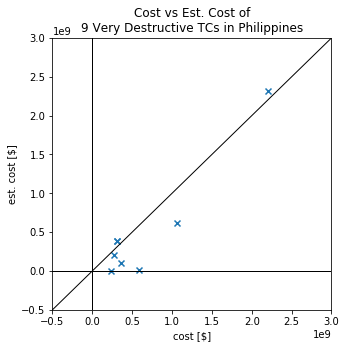

In [29]:
# Zoom out plot to include all points
plt.figure(figsize=(5, 5))
plt.scatter(cost_des,est_cost,marker='x')
plt.xlabel('cost [$]')
plt.ylabel('est. cost [$]')
plt.plot([-1e9,3e9],[-1e9,3e9],color='k',linewidth=1)
plt.xlim([-0.5e9,3e9])
plt.ylim([-0.5e9,3e9])
plt.hlines(0,-0.5e20,2.5e20,linewidth=1)
plt.vlines(0,-0.5e20,2.5e20,linewidth=1)
plt.title('Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

In [30]:
ds_asset_losses_des = xr.DataArray.to_dataset(asset_losses,name='asset_losses')
ds_asset_losses_des.to_netcdf(root_dir+'/ASSET_LOSSES/IBTrACS/regionvulnerability_des_rmsf_2.nc')


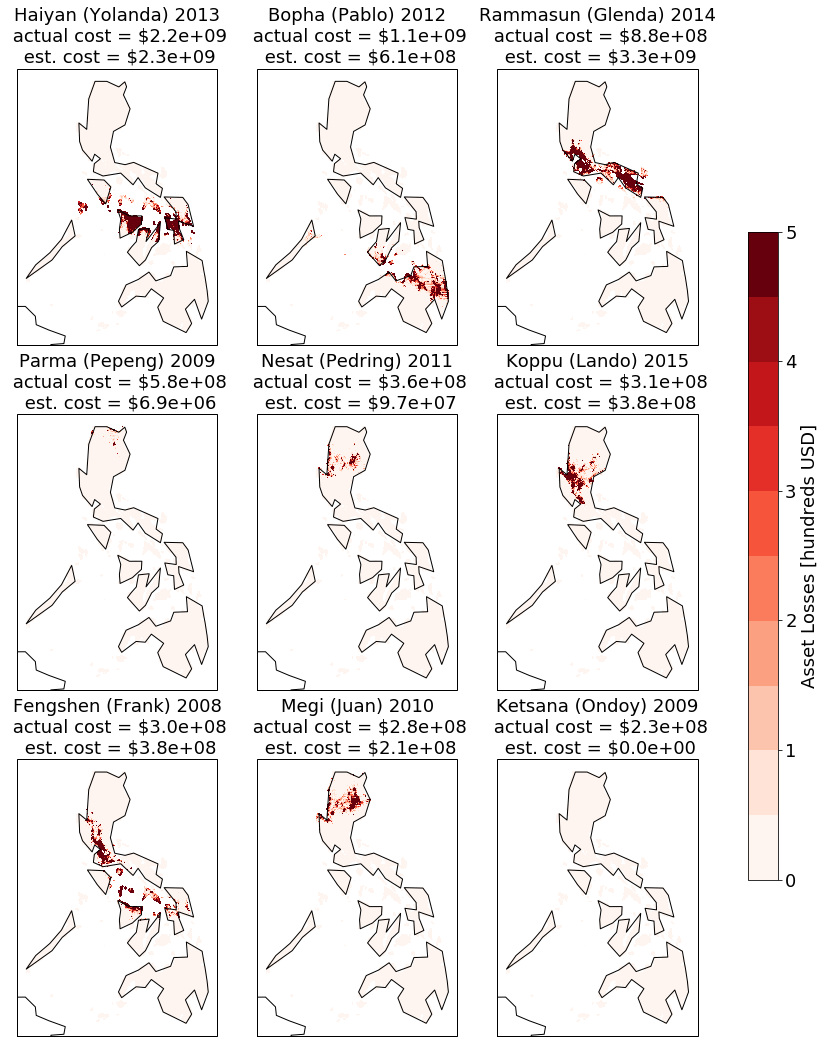

In [31]:
fig = plt.figure(figsize=(14, 18))
plt.rcParams.update({'font.size': 18})
for n in np.arange(len(name_des)):
    plt.subplot(3,3,n+1,projection=ccrs.PlateCarree())
    p = (asset_losses[...,n]/100).plot(levels=np.arange(0,5.50,0.50),transform=ccrs.PlateCarree(),cmap=plt.cm.Reds,add_colorbar=False)
    p.axes.coastlines()
    plt.title(name_des[n]+' '+str(dt_des[n].year)+'\n actual cost = $'+"{:.1e}".format(int(cost_des[n]),decimals=1)+'\n est. cost = $'+"{:.1e}".format(int(est_cost[n])),fontsize=18)
    #cb = plt.colorbar(p, orientation="vertical", pad=0.15)
    #cb.set_label(label='Asset Losses [USD]',fontsize=16)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.set_label('Asset Losses [hundreds USD]', rotation=90)
plt.savefig(root_dir+'/FIGURES/assetlossmaps_9storms_rmsf_2.png',dpi=400)

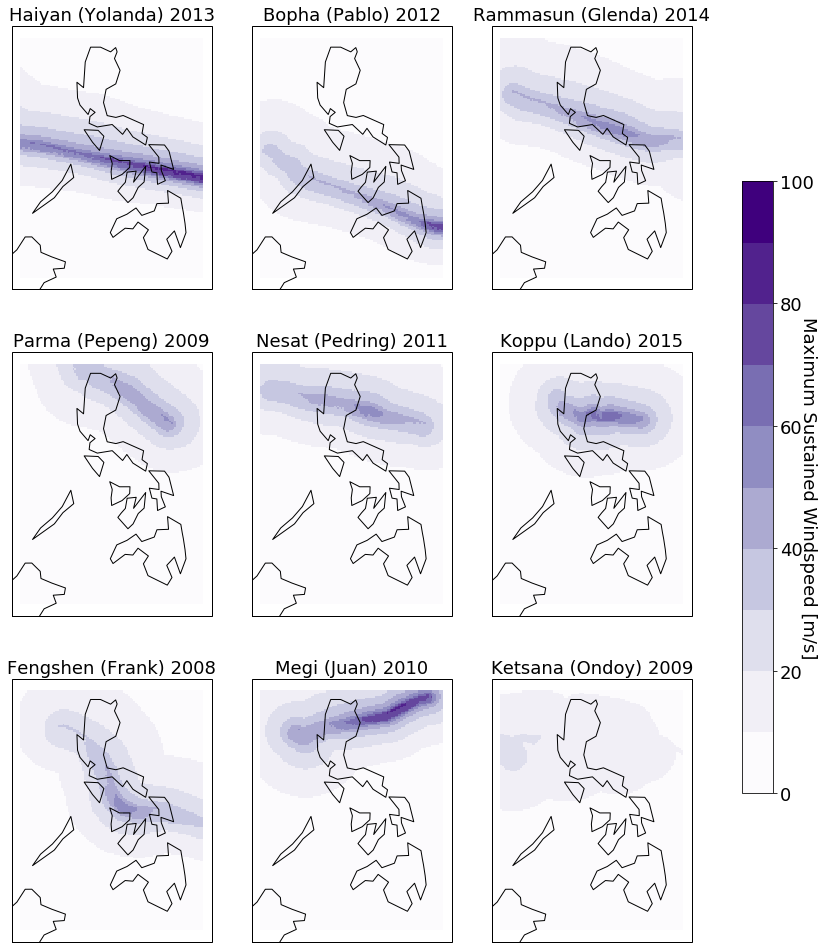

In [32]:
fig = plt.figure(figsize=(14,17))
plt.rcParams.update({'font.size': 18})
for n in np.arange(len(name_des)):
    ax = plt.subplot(3,3,n+1,projection=ccrs.PlateCarree())
    p = swath_des[n].plot(transform=ccrs.PlateCarree(),cmap = plt.cm.Purples,levels=np.arange(0,110,10),add_colorbar=False)
    plt.title(name_des[n]+' '+str(dt_des[n].year),fontsize=18)
    ax.coastlines(color='k')
    #cb = plt.colorbar(p, orientation="vertical", pad=0.15)
    #cb.set_label(label='Maximum Sustained Windspeed [m/s]',fontsize=16)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.set_label('Maximum Sustained Windspeed [m/s]', rotation=270)
plt.savefig(root_dir+'/FIGURES/windswathmaps_9storms_rmsf_2.png',dpi=400)